# Sberbank Russian Housing Market

In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import seaborn as sns
from sklearn import model_selection, preprocessing
# import visualization as vis
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
color = sns.color_palette()

DIR_PATH = './'

In [2]:
pd.__path__

['/usr/local/lib/python2.7/site-packages/pandas']

In [3]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')

### Data Understanding & Data Preparation

In [4]:
## data schema
train_schema = pd.DataFrame(build_table_schema(train_raw)['fields'])
macro_schema = pd.DataFrame(build_table_schema(macro)['fields'])

In [5]:
## start from property features first
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

train = train_raw[property_features]
test = test_raw[property_features[:-1]]

## Cleaning the property features

## full_sq:

In [6]:
# <10 -> NA
train.loc[train['full_sq'] <10, 'full_sq'] = np.nan
test.loc[test['full_sq'] <10, 'full_sq'] = np.nan

# >300 -> NA
train.loc[train['full_sq'] > 300, 'full_sq'] = np.nan
test.loc[test['full_sq'] > 300, 'full_sq'] = np.nan

## life_sq:

In [7]:
# 0 or 1 -> NA
train.loc[(train['life_sq'] == 0) | (train['life_sq'] == 1), 'life_sq'] = np.nan
test.loc[(test['life_sq'] == 0) | (test['life_sq'] == 1), 'life_sq'] = np.nan

# > 300 -> NA
train.loc[train['life_sq'] > 300, 'life_sq'] = np.nan
test.loc[test['life_sq'] > 300, 'life_sq'] = np.nan

# full_sq < life_sq & life_sq > 100 -> NA
train.loc[(train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100), 'life_sq'] = np.nan
test.loc[(test['full_sq'] < test['life_sq']) & (test['life_sq'] > 100), 'life_sq'] = np.nan

## max_floor:

In [8]:
# # 117 -> 17
train.loc[train['max_floor'] == 117, 'max_floor'] = 17
test.loc[test['max_floor'] == 117, 'max_floor'] = 17

# floor > max_floor -> NA
train.loc[train['floor'] > train['max_floor'], 'max_floor'] = np.nan
test.loc[test['floor'] > test['max_floor'], 'max_floor'] = np.nan

# >60 -> NA
train.loc[train['max_floor'] > 60, 'max_floor'] = np.nan
test.loc[test['max_floor'] > 60, 'max_floor'] = np.nan

# 0 -> NA
train.loc[train['max_floor'] == 60, 'max_floor'] = np.nan
test.loc[test['max_floor'] == 60, 'max_floor'] = np.nan

## material:

In [9]:
# 3 -> NA
col = 'material'
train.loc[train[col] == 3, col] = np.nan
test.loc[test[col] == 3, col] = np.nan

## build_year:

In [10]:
# 20052009 -> 2009 
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
test.loc[test['build_year'] == 20052009, 'build_year'] = 2009

#  4965 -> 1965
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
test.loc[test['build_year'] == 4965, 'build_year'] = 1965

#  71 -> 1971
train.loc[train['build_year'] == 71, 'build_year'] = 1971
test.loc[test['build_year'] == 71, 'build_year'] = 1971

#  <1800 -> NA
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

## num_room:

In [11]:
# >9 -> NA
train.loc[train['num_room'] > 9, 'num_room'] = np.nan
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

## kitch_sq:

In [12]:
# kitch_sq > full_sq & kitch_sq > 100 -> NA
train.loc[(train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100), 'kitch_sq'] = np.nan
test.loc[(test['kitch_sq'] > test['full_sq']) & (test['kitch_sq'] > 100), 'kitch_sq'] = np.nan

## state:

In [13]:
## 33 -> 3
train.loc[train['state'] == 33, 'state'] = 3
test.loc[test['state'] == 33, 'state'] = 3

# Merging

## 1- Merge cleaned datasets with raw datasets

Merging the datasets (raw and cleaned):

In [14]:
train_raw_small = train_raw.ix[:, train_raw.columns.difference(property_features)]

property_features_test = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area']
test_raw_small = test_raw.ix[:, test_raw.columns.difference(property_features_test)]

In [15]:
merged_df_train = pd.concat([train, train_raw_small], axis=1)
merged_df_test = pd.concat([test, test_raw_small], axis=1)

In [16]:
# saving the datasets to csvs
merged_df_train.to_csv('train_cleaned.csv')
merged_df_test.to_csv('test_cleaned.csv')

## 2- Merge cleaned datasets with macro

Merging the newly created dataset with macro (for train dataset):

In [17]:
type(merged_df_train.timestamp.iloc[0])
type(macro.timestamp.iloc[0])

# convert merged_df_train timestamp to string:
merged_df_train['timestamp'] = merged_df_train.timestamp.map(lambda x: str(x)[:10])

In [18]:
print type(merged_df_train.timestamp.iloc[0])
print type(macro.timestamp.iloc[0])

<type 'str'>
<type 'str'>


In [19]:
# make id a column. If we keep it as an index, it gets dropped when we merge
merged_df_train['id'] = merged_df_train.index
merged_df_test['id'] = merged_df_test.index

In [20]:
pd_full_train = pd.merge(merged_df_train, macro, on = 'timestamp', how='left')
pd_full_test = pd.merge(merged_df_test, macro, on = 'timestamp', how='left')

# Missing Values

### Looking at missing values (after a little bit of cleaning)

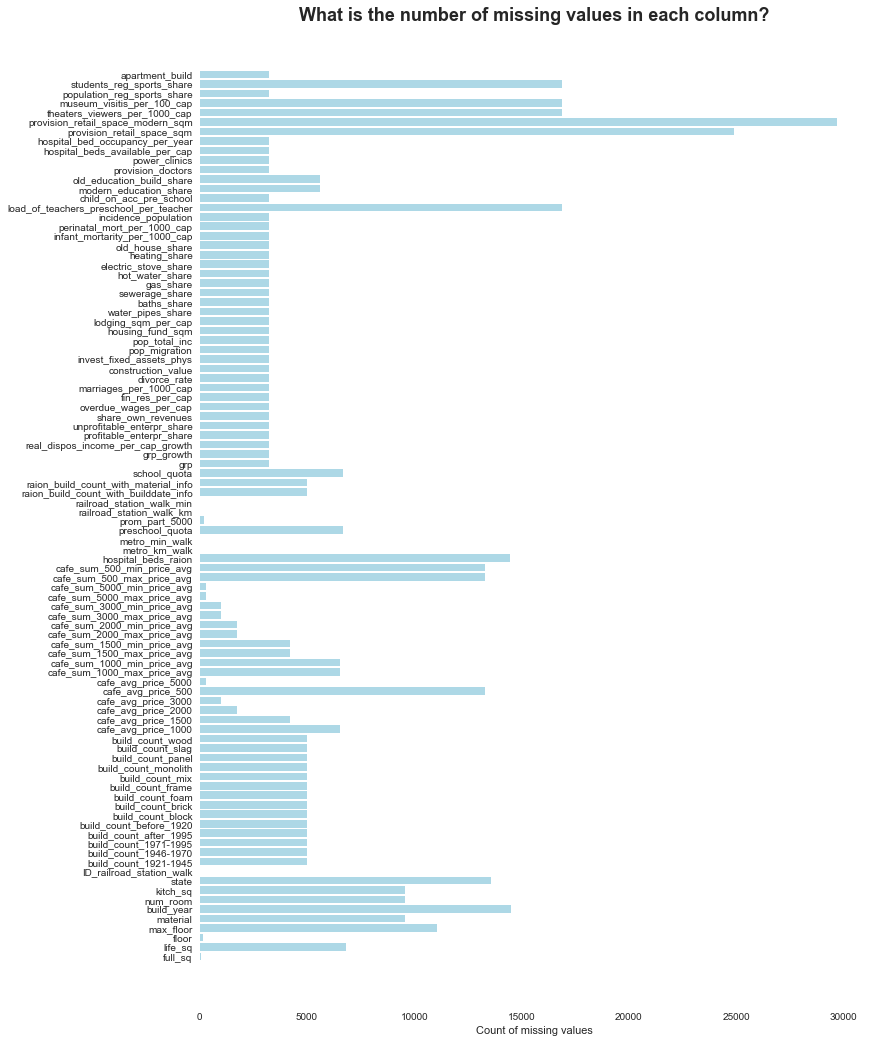

In [21]:
missing_df = pd_full_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='lightblue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("What is the number of missing values in each column?", weight = 'bold', size = 18)
ax.set_axis_bgcolor('white')
plt.show()

# Important Variables

### Doing feature selection using RF and XG boost. 
We will use EDA to refine the process of selecting our features.

#### Using XGboost

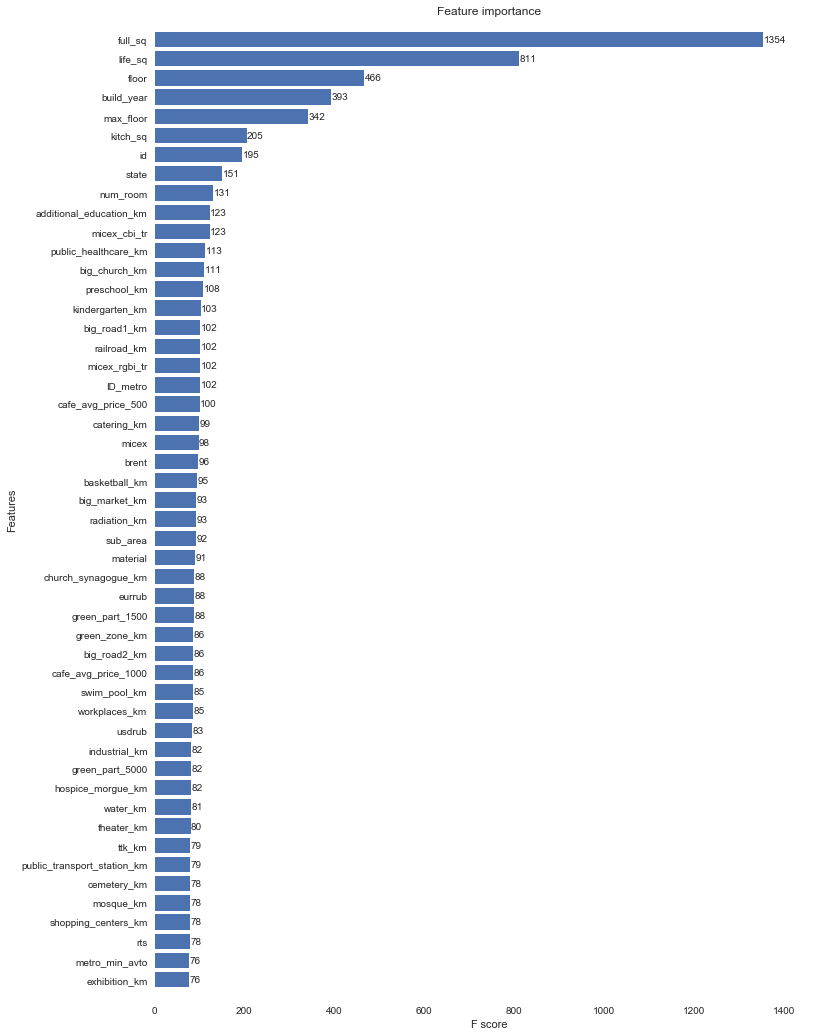

In [22]:
for f in pd_full_train.columns:
    if pd_full_train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(pd_full_train[f].values)) 
        pd_full_train[f] = lbl.transform(list(pd_full_train[f].values))
        
train_y = pd_full_train.price_doc.values
train_X = pd_full_train.drop(["timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.set_axis_bgcolor('white')
plt.show()

#### Using Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train = train_raw.drop(labels=['timestamp', 'incineration_raion'], axis=1).dropna()
y_train = X_train['price_doc']
X_train.drop('price_doc', axis=1, inplace=True)
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(X_train[f])
        X_train[f] = lbl.transform(X_train[f])
rf = RandomForestRegressor(random_state=0)
rf = rf.fit(X_train, y_train)

In [24]:
fi = list(zip(X_train.columns, rf.feature_importances_))
print('## rf variable importance')
d = ['## %-40s%s' % (i) for i in fi[:20]]
d

## rf variable importance


['## full_sq                                 0.555822740983',
 '## life_sq                                 0.00642379194562',
 '## floor                                   0.00809202108709',
 '## max_floor                               0.0028673165125',
 '## material                                0.000990753188025',
 '## build_year                              0.0129793747626',
 '## num_room                                0.00160862516711',
 '## kitch_sq                                0.00737577768977',
 '## state                                   0.00300109689575',
 '## product_type                            0.000774585117786',
 '## sub_area                                0.000408328391516',
 '## area_m                                  0.0002262017504',
 '## raion_popul                             0.000110012923241',
 '## green_zone_part                         0.00323341734379',
 '## indust_part                             0.00195929983016',
 '## children_preschool                  

# Feature Selection

#### Now that we have a good understanding of the important variables, we'll do a quick EDA to refine our feature selection process.

In [25]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(pd_full_train.price_doc.values, 99)
llimit = np.percentile(pd_full_train.price_doc.values, 1)
pd_full_train['price_doc'].ix[pd_full_train['price_doc']>ulimit] = ulimit
pd_full_train['price_doc'].ix[pd_full_train['price_doc']<llimit] = llimit

Convert categorical variables into numerical variables by label encoding.

In [26]:
for f in pd_full_train.columns:
    if pd_full_train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(pd_full_train[f].values.astype('str')) + list(pd_full_test[f].values.astype('str')))
        pd_full_train[f] = lbl.transform(list(pd_full_train[f].values.astype('str')))
        pd_full_test[f] = lbl.transform(list(pd_full_test[f].values.astype('str')))

Create dataset with only the variables from XG Boost algorithm

In [27]:
xgb_features = ["full_sq", "life_sq", "floor", "build_year", "max_floor", "kitch_sq",
           "state", "additional_education_km", "public_transport_station_km", 
           "num_room", "ID_metro", "big_church_km", "sub_area",
           "preschool_km", "cafe_avg_price_500", "big_road2_km", "green_zone_km",
          "kindergarten_km", "catering_km", "big_road1_km", 
           "public_healthcare_km", "hospice_morgue_km", "swim_pool_km", "material", 
           "green_part_1000", "railroad_km", "industrial_km", "cemetery_km",
           "fitness_km", "theater_km", "radiation_km", "id", "price_doc"]

xgb_features_noprice = ["full_sq", "life_sq", "floor", "build_year", "max_floor", "kitch_sq",
           "state", "additional_education_km", "public_transport_station_km", 
           "num_room", "ID_metro", "big_church_km", "sub_area",
           "preschool_km", "cafe_avg_price_500", "big_road2_km", "green_zone_km",
          "kindergarten_km", "catering_km", "big_road1_km", 
           "public_healthcare_km", "hospice_morgue_km", "swim_pool_km", "material", 
           "green_part_1000", "railroad_km", "industrial_km", "cemetery_km",
           "fitness_km", "theater_km", "radiation_km", "id"]

In [28]:
train_reduced_xgboost = pd_full_train[xgb_features]
test_reduced_xgboost = pd_full_test[xgb_features_noprice]

#### Checking proportion of null values in reduced train and test datasets:

In [29]:
null_values_train = train_reduced_xgboost.isnull().sum(axis=0) / len(train_reduced_xgboost) * 100
null_values_train[null_values_train > 0]

full_sq                0.141118
life_sq               22.427882
floor                  0.548062
build_year            47.612484
max_floor             36.323061
kitch_sq              31.429884
state                 44.498047
num_room              31.426602
cafe_avg_price_500    43.585704
material              31.416757
dtype: float64

In [30]:
null_values_test = test_reduced_xgboost.isnull().sum(axis=0) / len(test_reduced_xgboost) * 100
null_values_test[null_values_test > 0]

full_sq                0.065257
life_sq               19.720700
build_year            20.973636
max_floor              8.392065
kitch_sq               0.026103
state                  9.057687
num_room               0.013051
cafe_avg_price_500    41.229444
material               0.013051
dtype: float64

The **variables that are worth looking at for imputation** are: `life_sq`, `build_year`, `max_floor`, `kitch_sq`, `state`, `num_room`, `cafe_avg_price_500` and `material`.

For the 2 other variable with a low number of null values in both the test and train datasets (i.e. `full_sq` and `floor`), we will use the median (`full_sq`) and mode (`floor`).

### life_sq

We may be able to infer the values for `life_sq` from `full_sq` or **dismiss these values altogether if they are correlated to `full_sq`.**

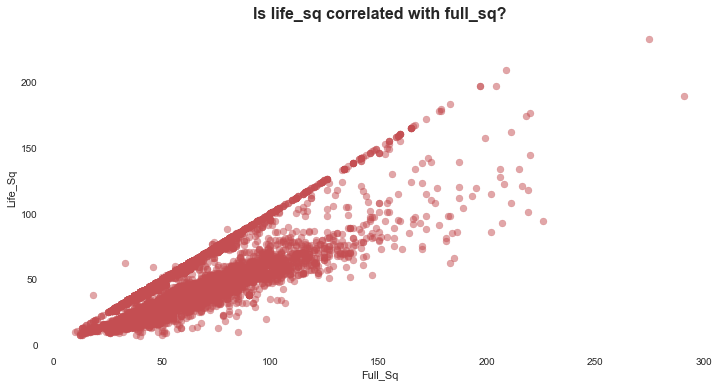

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['full_sq'], y=train_reduced_xgboost.drop(ind)['life_sq'], color=color[2], alpha=0.5)
ax.set(xlabel='Full_Sq', ylabel='Life_Sq')
ax.set_title('Is life_sq correlated with full_sq?',fontsize=16, weight='bold')

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('full_sq ~ life_sq',
                data=train_reduced_xgboost).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

                sum_sq       df             F  PR(>F)
life_sq   7.375627e+06      1.0  60111.740272     0.0
Residual  2.898264e+06  23621.0           NaN     NaN


In [33]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
esq_sm # out of the total variation in life_sq, 72% can be attributed to a full_sq.

0.71790007202278538

##### We won't use life_sq as it is highly correlated with full_sq. No need to impute missing values.

### build_year

Is `build_year` correlated with another variable? It could be correlated to `state`. However `state` has a lot of missing variables so if there are correlated, we may prefer to keep `build_year` and drop `state`.

##### Checking the correlation between `build_year` and `state`

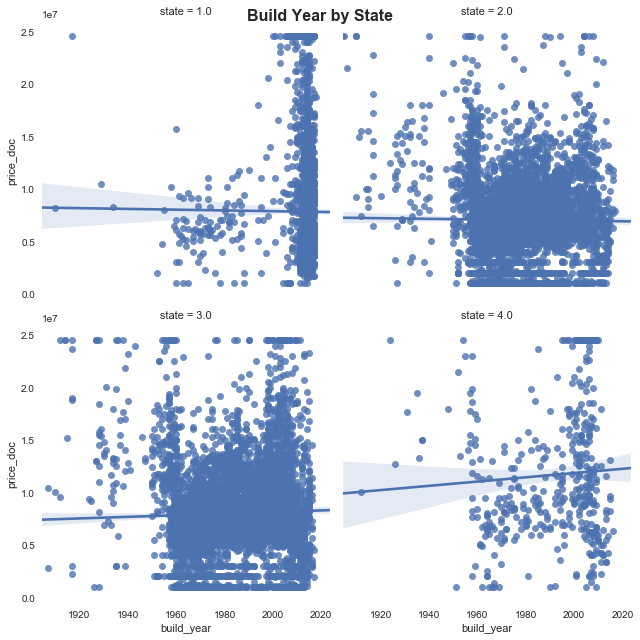

In [34]:
g = sns.FacetGrid(train_reduced_xgboost, col="state", col_wrap=2, size=4.5) 
g.set(axis_bgcolor='white')
g.fig.suptitle('Build Year by State', size = 16, weight = 'bold')
g.map(sns.regplot, "build_year", "price_doc") 

It is hard to see a relationship between `state` and `build_year`. There does not seem to be a relationship between neither `build_year` and `price` nor `build_year` and `state`.

**We can't infer build_year from another variable and will need to find a way to impute it.**

### max_floor

Can we infer max_floor from another variable? E.g. **is max_floor correlated with build_year?**

In [35]:
grouped_df = train_reduced_xgboost.groupby('build_year')['max_floor'].aggregate(np.mean).reset_index()

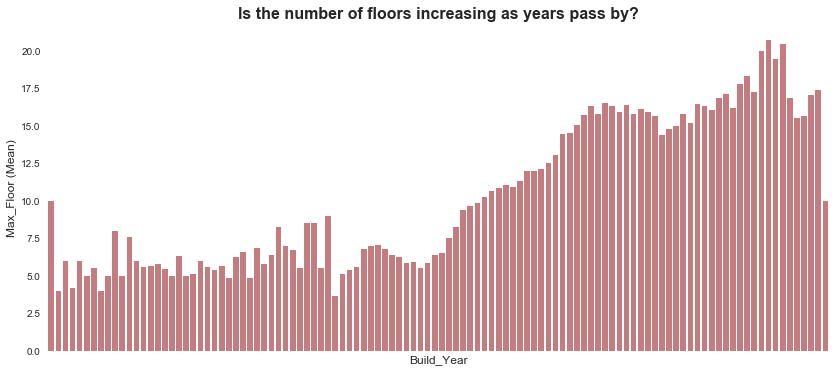

In [36]:
import matplotlib.ticker as ticker
from matplotlib.ticker import *

fig, ax = plt.subplots(figsize=(14,6))
ax.set_axis_bgcolor('white')
sns.barplot(grouped_df['build_year'], grouped_df['max_floor'], alpha=0.8, color=color[2])
plt.ylabel('Max_Floor (Mean)', fontsize=12)
plt.xlabel('Build_Year', fontsize=12)
ax.set_title("Is the number of floors increasing as years pass by?",fontsize=16, weight='bold')
# plt.xticks(rotation='vertical')
ax.set_xticks([])
plt.show()

**The number of floors increase has the years pass by**. Taking a closer look at the correlation between `build_year` and `max_floor`:

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('build_year ~ max_floor',
                data=train_reduced_xgboost).fit()
                
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print aov_table_2

                 sum_sq       df            F  PR(>F)
max_floor  2.812396e+06      1.0  11407.75674     0.0
Residual   3.840994e+06  15580.0          NaN     NaN


In [38]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table_2['sum_sq'][0]/(aov_table_2['sum_sq'][0]+aov_table_2['sum_sq'][1])
esq_sm # out of the total variation in max_floor, 42% can be attributed to the build year.

0.42270118445866595

**The eta squared is too low between `max_floor` and `build_year`**. We will keep both variables and will need to impute `max_floor`.

### kitch_sq

Is there a correlation between kitch_sq and full_sq?

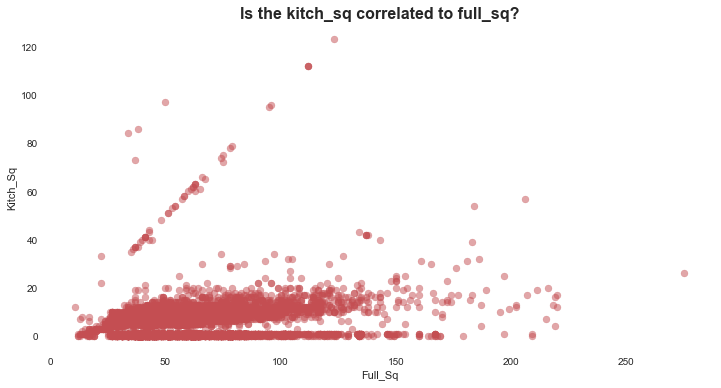

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['full_sq'], y=train_reduced_xgboost.drop(ind)['kitch_sq'], color=color[2], alpha=0.5)
ax.set(xlabel='Full_Sq', ylabel='Kitch_Sq')
ax.set_title("Is the kitch_sq correlated to full_sq?",fontsize=16, weight='bold')

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('kitch_sq ~ full_sq',
                data=train_reduced_xgboost).fit()
                
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print aov_table_2

                 sum_sq       df           F         PR(>F)
full_sq    12428.421821      1.0  499.116679  2.828382e-109
Residual  519456.308563  20861.0         NaN            NaN


**There is no clear correlation between kitch_sq and full_sq.** The p-value is too high.
We can't dismiss `kitch_sq` in our modeling and will need to impute it.

### state

We already saw that there was no relationship between `state` and `build_year`. **Is there a relationship between `state` and `material`?**

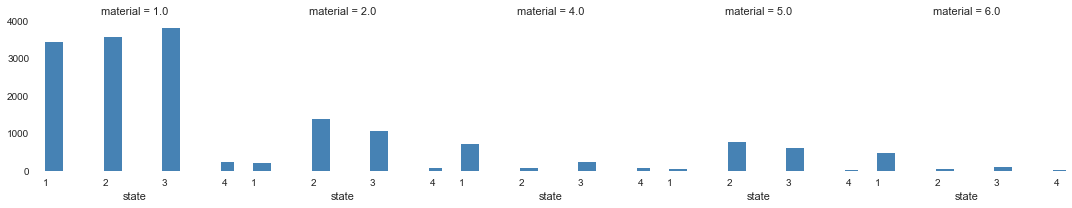

In [41]:
g = sns.FacetGrid(train_reduced_xgboost, col="material") 
g.set(axis_bgcolor='white')
# g.fig.suptitle('State by Material', size = 16, weight = 'bold')
bins = np.linspace(1, 4)
g.map(plt.hist, "state", color="steelblue", bins=bins, lw=0, width = 0.3)

**`Material` is not a good predictor of `state`**. We will need to choose a different way to impute `state`.

### num_room

Looking for a possible correlation between `num_room` and `full_sq`:

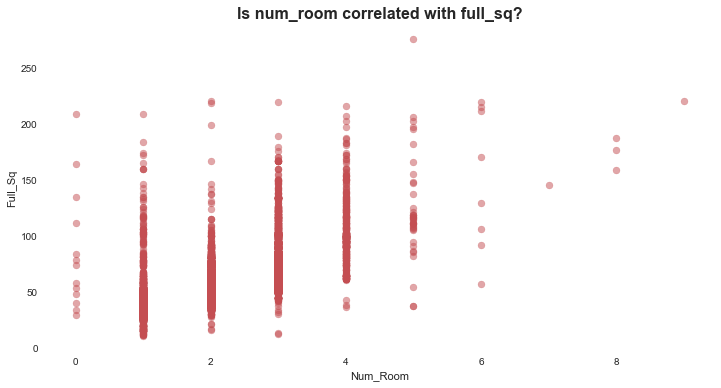

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['num_room'], y=train_reduced_xgboost.drop(ind)['full_sq'], 
            color=color[2], alpha=0.5)
ax.set(xlabel='Num_Room', ylabel='Full_Sq')
ax.set_title('Is num_room correlated with full_sq?',fontsize=16, weight='bold')

In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('full_sq ~ num_room',
                data=train_reduced_xgboost).fit()
                
aov_table_3 = sm.stats.anova_lm(mod, typ=2)
print aov_table_3

                sum_sq       df             F  PR(>F)
num_room  5.113924e+06      1.0  27633.667889     0.0
Residual  3.860750e+06  20862.0           NaN     NaN


In [44]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table_3['sum_sq'][0]/(aov_table_3['sum_sq'][0]+aov_table_3['sum_sq'][1])
esq_sm # out of the total variation in num_room, 57% can be attributed to full_sq.

0.56981724537205269

The p-value is low and eta squared relatively high so we can assume a correlation between `full_sq` and `num_room`.
To keep our model as simple as possible, **we will drop `num_room`. The number of missing values is high for `num_room` and given that it is correlated to `full_sq`, it will be more accurate to drop it rather than impute it**.

### cafe_avg_price_500

The variable `cafe_avg_price_500` looks at the cafes and restaurant's average bill within a 500 meters radius. 

In [45]:
train_reduced_xgboost['cafe_avg_price_500'].head(10)

0        NaN
1    1180.00
2     916.67
3    1250.00
4     934.44
5    1312.50
6    1000.00
7    1312.50
8     858.33
9     575.00
Name: cafe_avg_price_500, dtype: float64

Looking at a possible correlation between the `cafe_avg_price_500` and `price_doc`

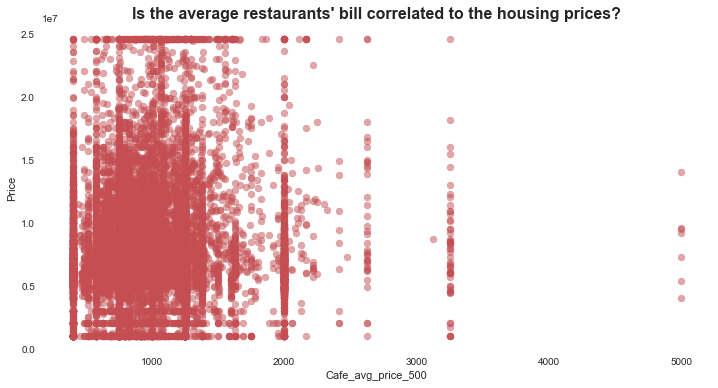

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['cafe_avg_price_500'], y=train_reduced_xgboost.drop(ind)['price_doc'], 
            color=color[2], alpha=0.5)
ax.set(xlabel='Cafe_avg_price_500', ylabel='Price')
ax.set_title("Is the average restaurants' bill correlated to the housing prices?",fontsize=16, weight='bold')

**No correlation between average restaurants' bill and housing prices**. 
There may be a possible correlation with `sub_area`. However, the correlation is unclear and imputing `cafe_avg_price_500` based on `sub_area` may be more prone to errors than using random imputation (which we will use instead).

### material

We already saw that material did not correlate with state. It does not correlate with any features related to the house as shown in the correlation plot below so we'll impute it.

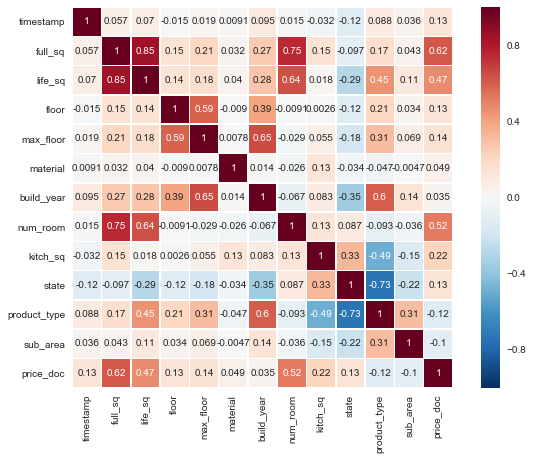

In [47]:
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

corrmat = pd_full_train[property_features].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

### school

The variables related to `school` were not part of the important variables from the xgboost model. However the variable selection performed by random forest included `children_preschool`, `preschool_quota`, `preschool_education_centers_raion`, `children_school`, `school_quota` as important variables.

We will include them in our model for now and play with them.

##### Looking at the correlation plot for all the school variables to decide the ones to pick:

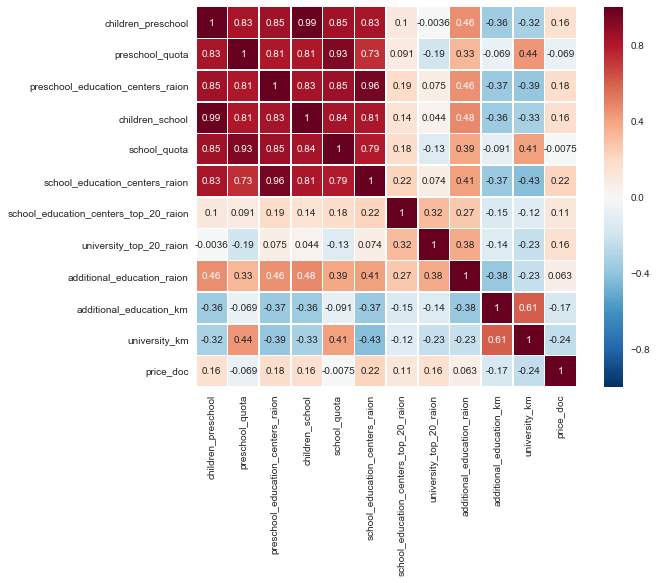

In [48]:
#school features
school_features = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']

corrmat = pd_full_train[school_features].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

A few school variables are correlated (i.e. `children_preschool`, `preschool_quota`, `preschool_education_centers_raion`, `children_school`, `school_quota`, `school_education_centers_raion`). None of them seem to be higher correlated to `price_doc` than any other. We will look at the number of missing values and **pick the one that have the least number of missing values.**

In [49]:
school_list = ['children_preschool', 'preschool_quota', 
              'preschool_education_centers_raion', 
              'children_school', 'school_quota', 
              'school_education_centers_raion']
school_df = pd_full_train[school_list]

In [50]:
null_values_school = school_df.isnull().sum(axis=0) / len(school_df) * 100
null_values_school

children_preschool                    0.000000
preschool_quota                      21.948738
preschool_education_centers_raion     0.000000
children_school                       0.000000
school_quota                         21.938893
school_education_centers_raion        0.000000
dtype: float64

Only the `preschool_quote` and `school_quota` have missing values. **We will pick `children_preschool` as an indicator of all the school variables**: it is one of the school features that was selected by the random forest algorithm and it has no missing values.

## Feature Selection Summary

Based on the analysis above, we will perfom the following transformation to the features we selected:
- **DROP**: `life_sq`, `num_room`
- **ADD**: `children_preschool`
- **IMPUTE**: `build_year`, `max_floor`, `state`, `kitch_sq`, `cafe_avg_price_500`, `material`
- **KEEP**: all the remaining features

In [51]:
# updating the xgb feature list by adding children_preschool and dropping life_sq and num_room
xgb_features.append('children_preschool') 
xgb_features.remove('life_sq')
xgb_features.remove('num_room')

xgb_features_noprice.append('children_preschool') 
xgb_features_noprice.remove('life_sq')
xgb_features_noprice.remove('num_room')

In [53]:
train_reduced_xgboost = pd_full_train[xgb_features]
test_reduced_xgboost = pd_full_test[xgb_features_noprice]

## Missing Values (Imputation)

#### We have 32 features that we selected:
We will procede to cleaning the missing data as follow:
- remove observations that have more than 10 missing values
- use random to impute missing values for now. *We will adjust our imputation method when fine tuning the model (i.e. median, mode, knn, or let the model do the work)*

In [57]:
len(train_reduced_xgboost.columns)

32

### Remove observations with more than 10 missing values

In [67]:
max(train_reduced_xgboost.isnull().sum(axis=1)) # look at max number of missing values per observation

7

The maximum number of missing values per observation is 7 so we won't remove any observations.

### Use random to impute missing values

We will create a different dataframe for this one. Some models take care of the missing values so it will be interesting to compare the accuracy of the prediction when we feed a dataset with only complete cases vs. a dataset with missing values.

In [99]:
# using the the list of columns with null values created previously for the test and train datasets
col_with_nas_train = null_values_train[null_values_train>0].index
col_with_nas_train = col_with_nas_train[(col_with_nas_train != 'life_sq') & (col_with_nas_train != 'num_room')]

col_with_nas_test = null_values_test[null_values_test>0].index
col_with_nas_test = col_with_nas_test[(col_with_nas_test != 'life_sq') & (col_with_nas_test != 'num_room')]

In [108]:
train_reduced_xgboost_no_nas = train_reduced_xgboost
test_reduced_xgboost_no_nas = test_reduced_xgboost

In [109]:
for i in col_with_nas_train:
    train_reduced_xgboost_no_nas[i].fillna(lambda x: random.choice(df[df[i] != np.nan][i]), inplace = True)

In [110]:
for i in col_with_nas_test:
    test_reduced_xgboost_no_nas[i].fillna(lambda x: random.choice(df[df[i] != np.nan][i]), inplace = True)

In [111]:
train_reduced_xgboost_no_nas  
test_reduced_xgboost_no_nas

,full_sq,floor,build_year,max_floor,kitch_sq,state,additional_education_km,public_transport_station_km,ID_metro,big_church_km,...,material,green_part_1000,railroad_km,industrial_km,cemetery_km,fitness_km,theater_km,radiation_km,id,children_preschool
0,39,2,1998,9,8.9,3,0.514211,0.114134,45,0.749142,...,1,32.48,0.490549,1.205404,0.781053,0.225788,19.953413,6.620081,30474,14080
1,79.2,8,<function <lambda> at 0x12c80eaa0>,17,1,1,1.694967,0.826083,21,1.672126,...,1,67.43,2.342346,0.742377,2.244906,1.313180,13.006107,8.545593,30475,275
2,40.5,3,1960,5,4.8,2,2.330995,0.116686,44,1.400094,...,2,13.07,2.220941,0.900408,3.389848,0.966254,2.983875,0.826743,30476,6400
3,62.8,17,2016,17,62.8,3,0.403429,3.093209,45,5.411312,...,1,27.94,4.476081,0.466738,2.701804,4.480234,18.121220,9.434351,30477,489
4,40,17,<function <lambda> at 0x12c80eaa0>,17,1,1,1.339078,0.630014,21,1.192543,...,1,36.66,1.727223,0.353642,2.250137,1.519553,13.459593,9.036942,30478,275
5,48.43,21,2015,<function <lambda> at 0x12c80e848>,1,1,0.858923,0.264910,67,0.635582,...,1,9.99,0.042636,0.000000,2.479746,0.634820,2.795791,0.740870,30479,3903
6,38.8,15,<function <lambda> at 0x12c80eaa0>,17,1,1,0.509985,0.257288,72,3.407720,...,1,15.52,0.874445,0.631064,2.151334,0.564069,8.634607,4.687054,30480,8340
7,43.1,5,<function <lambda> at 0x12c80eaa0>,<function <lambda> at 0x12c80e848>,0,<function <lambda> at 0x12c80e6e0>,3.094514,0.636131,132,4.075378,...,1,29.57,5.608658,0.084083,1.849308,1.411455,10.423243,4.087702,30481,656
8,45.4,9,1972,12,6,2,2.920372,0.284019,21,3.736513,...,5,20.40,1.423014,1.574552,1.604601,4.013972,15.352267,11.079482,30482,1491
9,43.3,7,<function <lambda> at 0x12c80eaa0>,22,1,1,3.368557,0.971126,21,3.061736,...,1,79.14,1.587344,1.637731,0.586676,3.669399,20.215558,11.691173,30483,275


# Modeling

### Linear Regression

In [365]:
df = merged_df_train.drop(['price_doc'], axis=1)
np.array([c for c in df.columns if df[c].dtype == 'object'])
df['timestamp'] = pd.to_numeric(pd.to_datetime(df['timestamp'])) / 1e18
# This automatically only dummies object columns
df = pd.get_dummies(df).astype(np.float64)

X = df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [370]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline

# Make a pipeline that transforms X
pipe = make_pipeline(Imputer(), StandardScaler())
pipe.fit(X_train)
pipe.transform(X_train)

from sklearn.metrics import make_scorer

def rmsle_exp(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(np.mean(np.power(np.log(y_true + 1) - np.log(y_pred + 1), 2)))

def score_model(model, pipe):
    train_error = rmsle_exp(y_train, model.predict(pipe.transform(X_train)))
    test_error = rmsle_exp(y_test, model.predict(pipe.transform(X_test)))
    return train_error, test_error

from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(pipe.transform(X_train), y_train)

score_model(lr, pipe)

(price_doc    inf
 dtype: float64, price_doc    inf
 dtype: float64)

In [363]:
df = merged_df_train.drop(['id', 'price_doc'], axis=1)

# dataframe with only the numeric features
linear_df_train = merged_df_train[all_features_combined]

from sklearn import linear_model
y_train = linear_df_train[linear_df.columns.difference(['price_doc','timestamp', "incineration_raion", 
                                                        'state', 'product_type', 'sub_area', 'floor',
                                                        'max_floor', 'material', 'build_year', 'num_room',
                                                        'state', 'product_type', 'sub_area'])]
x_train = linear_df['price_doc']
x_test = merged_df_test[all_features_combined_noprice]

linear = linear_model.LinearRegression()

linear.fit(x_train, y_train)
linear.score(x_train, y_train)

print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

predicted= linear.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Random Forest

In [ ]:
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')